In [392]:
# Load necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

In [393]:
# Load the dataset
df = pd.read_excel('EastWestAirlines.xlsx', sheet_name='data')

# Display the first few rows of the dataset
df.head(10)

ID#  Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  \
0    1    28143           0          1          1          1          174   
1    2    19244           0          1          1          1          215   
2    3    41354           0          1          1          1         4123   
3    4    14776           0          1          1          1          500   
4    5    97752           0          4          1          1        43300   
5    6    16420           0          1          1          1            0   
6    7    84914           0          3          1          1        27482   
7    8    20856           0          1          1          1         5250   
8    9   443003           0          3          2          1         1753   
9   10   104860           0          3          1          1        28426   

   Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll  Award?  
0            1                  0                0               7000       0  
1            2                  0                0               6968       0  
2            4                  0                0               7034       0  
3            1                  0                0               6952       0  
4           26               2077                4               6935       1  
5            0                  0                0               6942       0  
6           25                  0                0               6994       0  
7            4                250                1               6938       1  
8           43               3850               12               6948       1  
9           28               1150                3               6931       1

In [394]:
# Total no.of rows and columns
df.shape

(3999, 12)

In [395]:
# Drop 'ID#' column and exclude 'Award?' column from the features
df.drop(columns=['ID#'], inplace=True)

# Display the columns to verify
print(df.columns)

Index(['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles',
       'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12',
       'Days_since_enroll', 'Award?'],
      dtype='object')


In [396]:
# Check for missing values
print(df.isnull().sum())

Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64


In [397]:
# Information about all the columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Balance            3999 non-null   int64
 1   Qual_miles         3999 non-null   int64
 2   cc1_miles          3999 non-null   int64
 3   cc2_miles          3999 non-null   int64
 4   cc3_miles          3999 non-null   int64
 5   Bonus_miles        3999 non-null   int64
 6   Bonus_trans        3999 non-null   int64
 7   Flight_miles_12mo  3999 non-null   int64
 8   Flight_trans_12    3999 non-null   int64
 9   Days_since_enroll  3999 non-null   int64
 10  Award?             3999 non-null   int64
dtypes: int64(11)
memory usage: 343.8 KB


In [398]:
# Define a function to detect outliers using the Z-score method
def detect_outliers_zscore(df, threshold=3):
    z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
    outliers = (z_scores > threshold).sum(axis=0)
    return outliers

# Detect outliers in the dataset
outliers = detect_outliers_zscore(df.drop(columns=['Award?']))
print("Outliers detected in each feature:\n", outliers)

Outliers detected in each feature:
 Balance              75
Qual_miles           83
cc1_miles             0
cc2_miles            43
cc3_miles            18
Bonus_miles          72
Bonus_trans          47
Flight_miles_12mo    78
Flight_trans_12      91
Days_since_enroll     0
dtype: int64


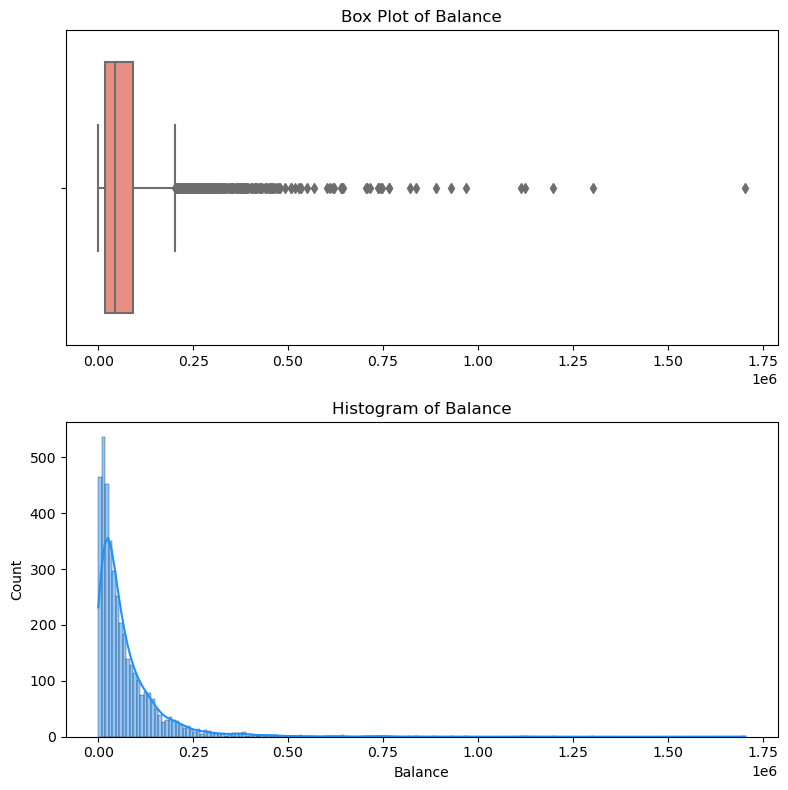

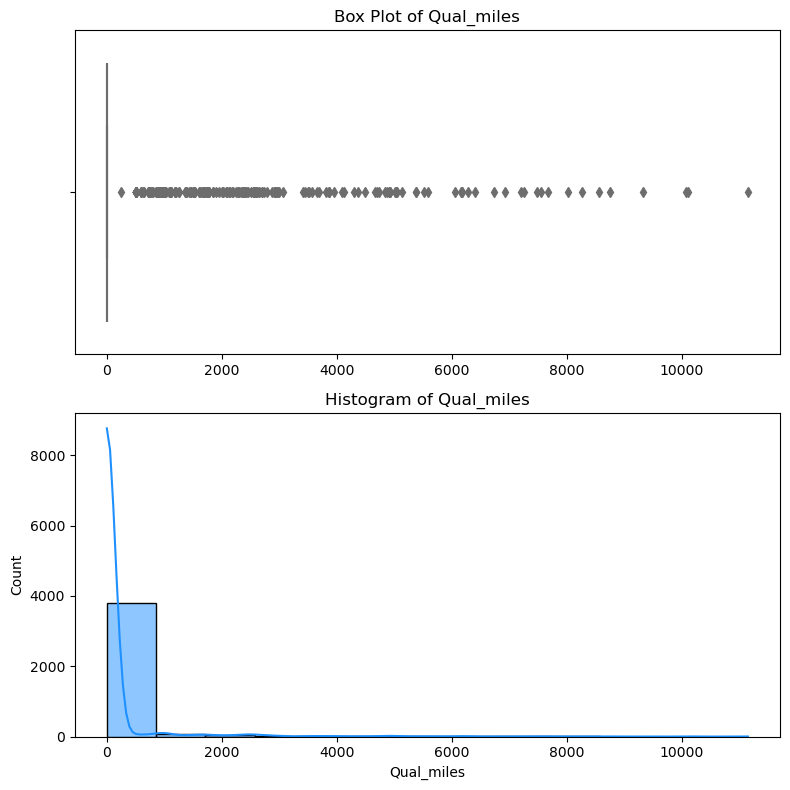

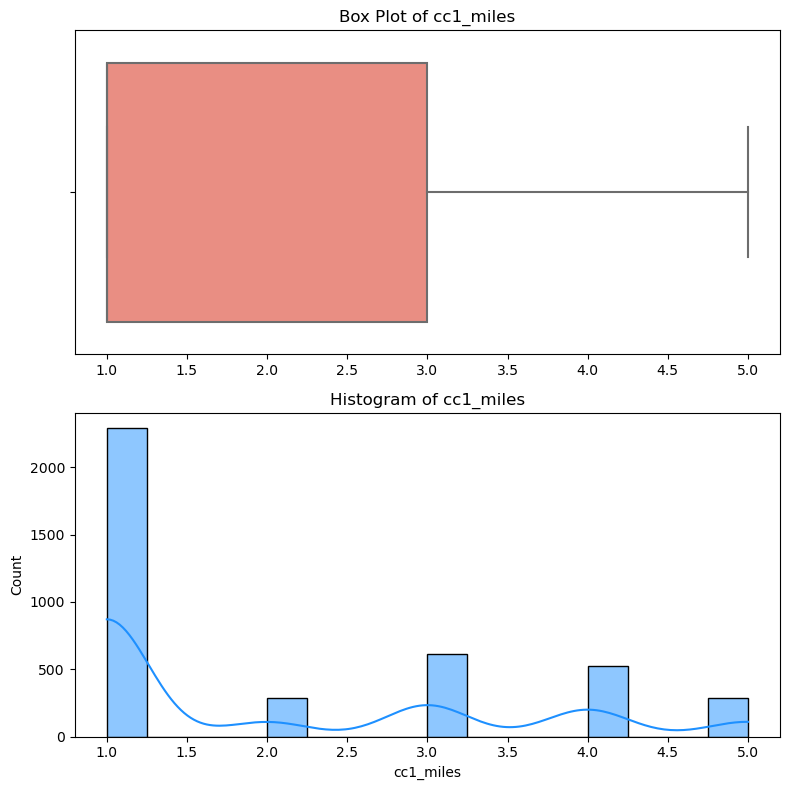

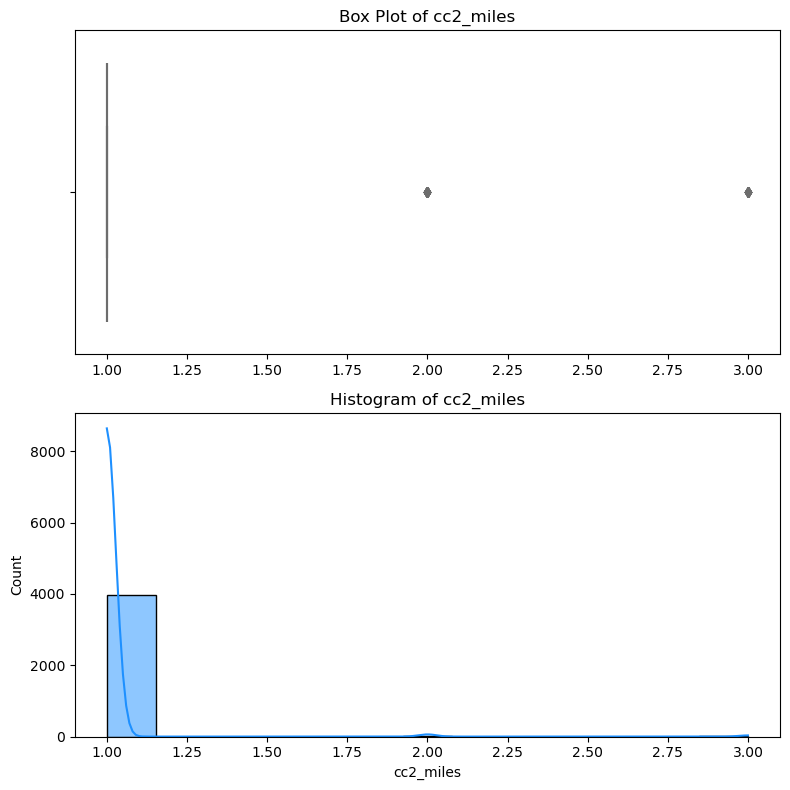

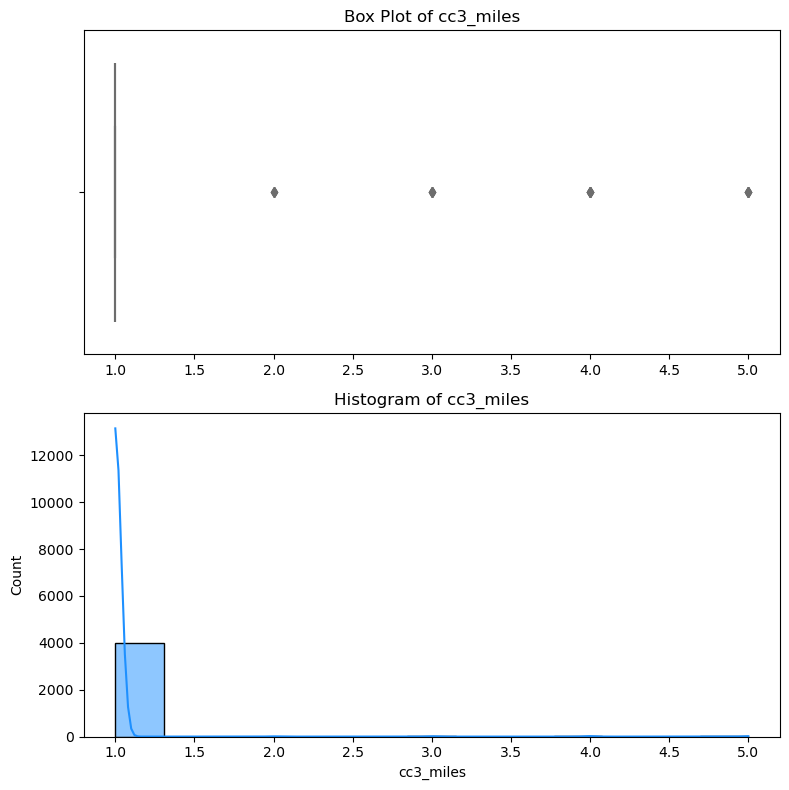

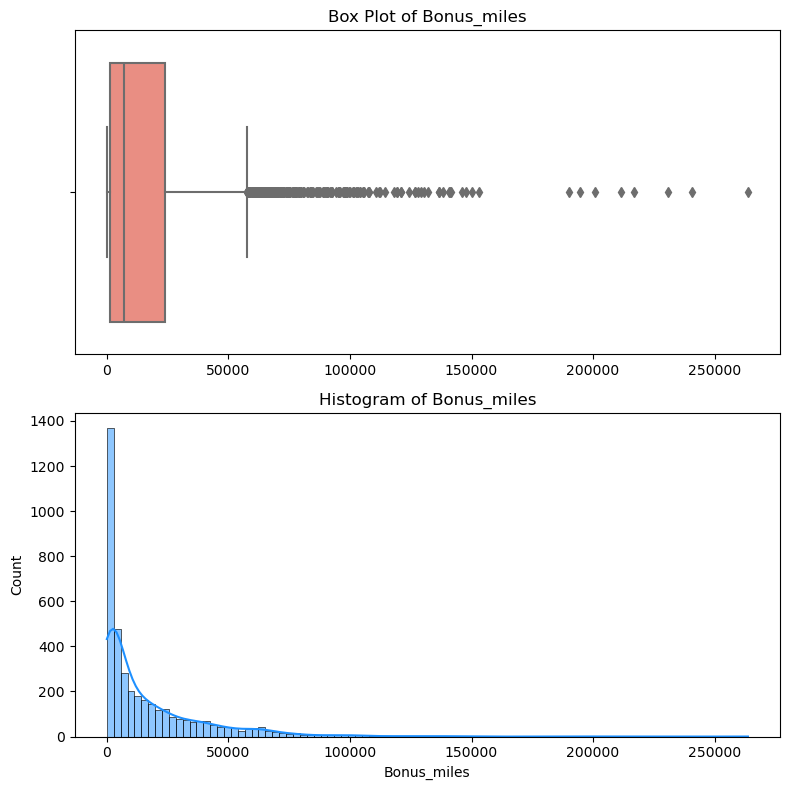

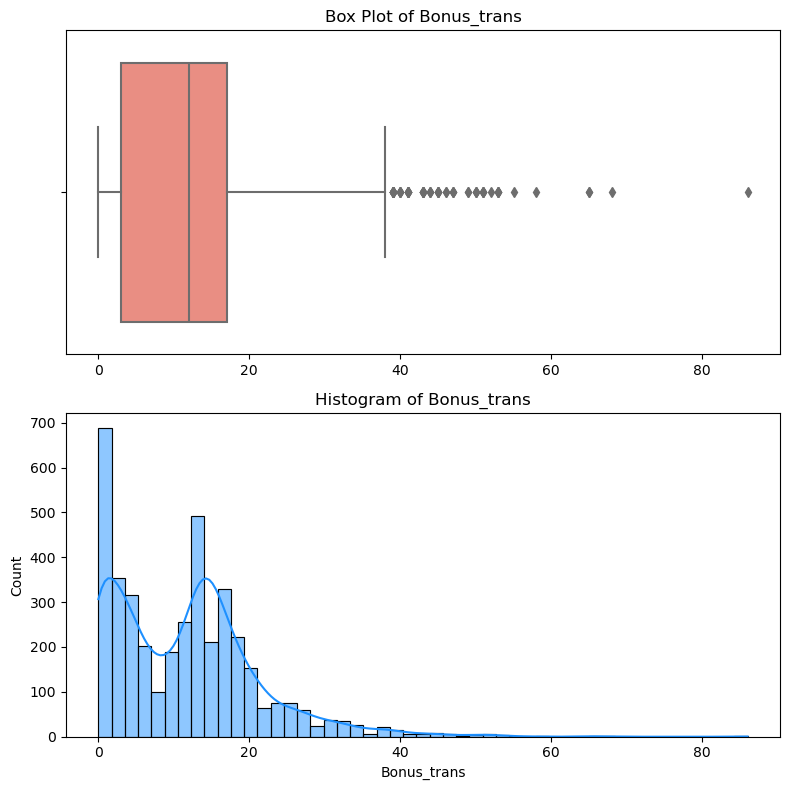

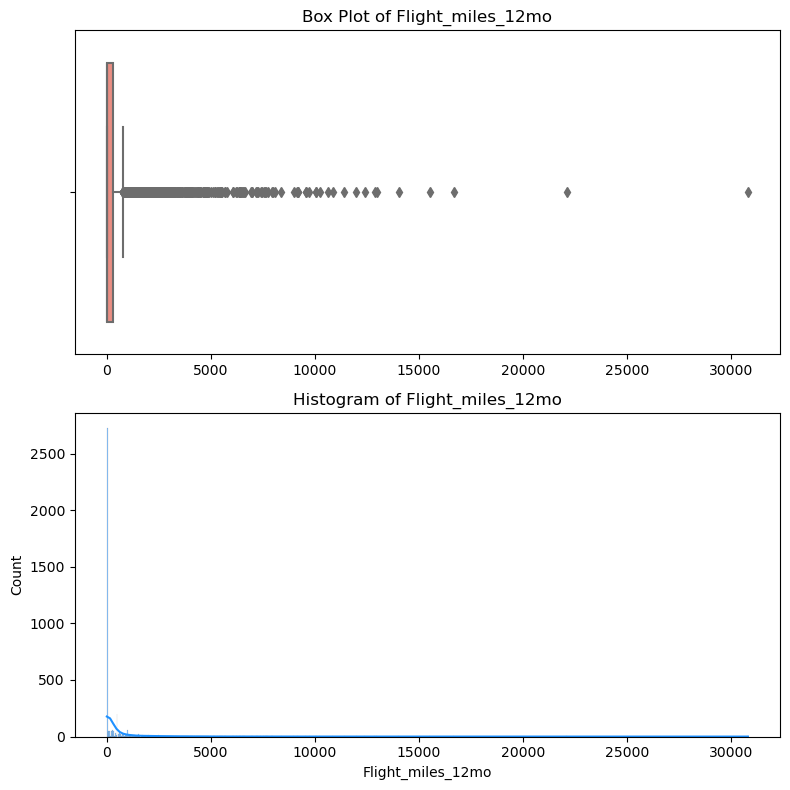

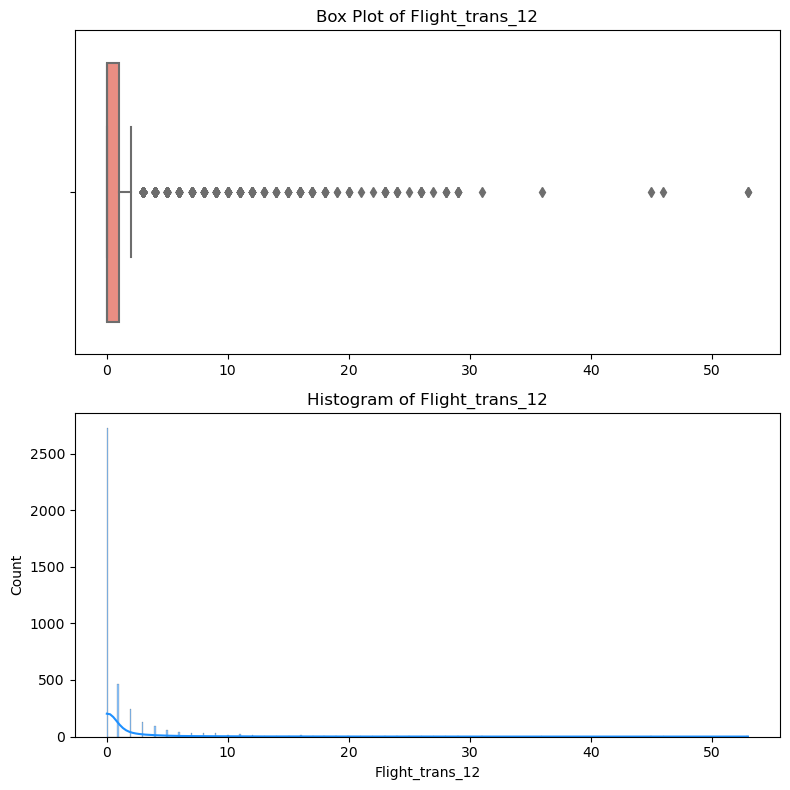

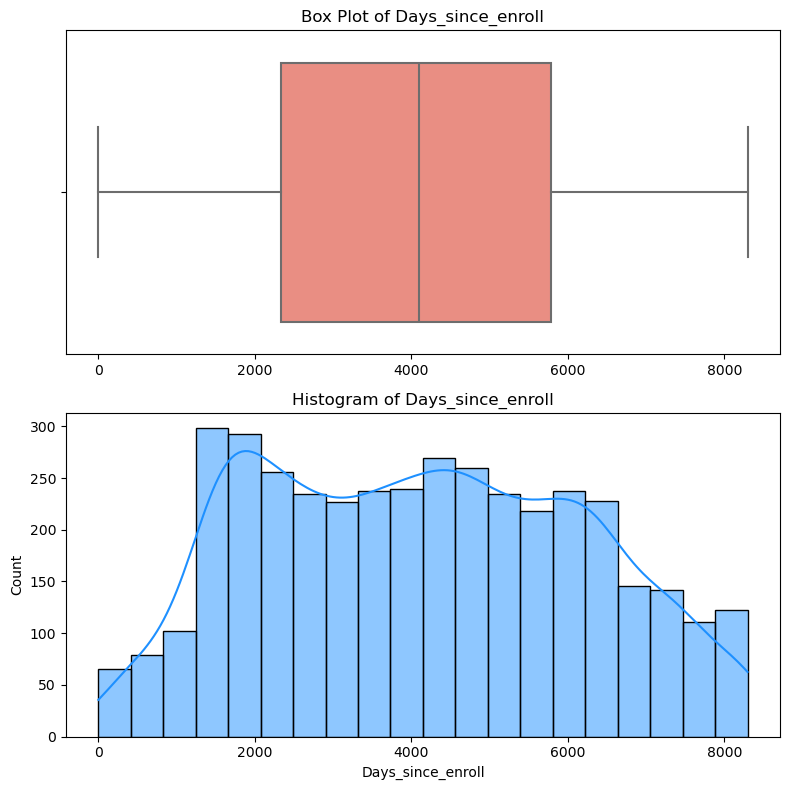

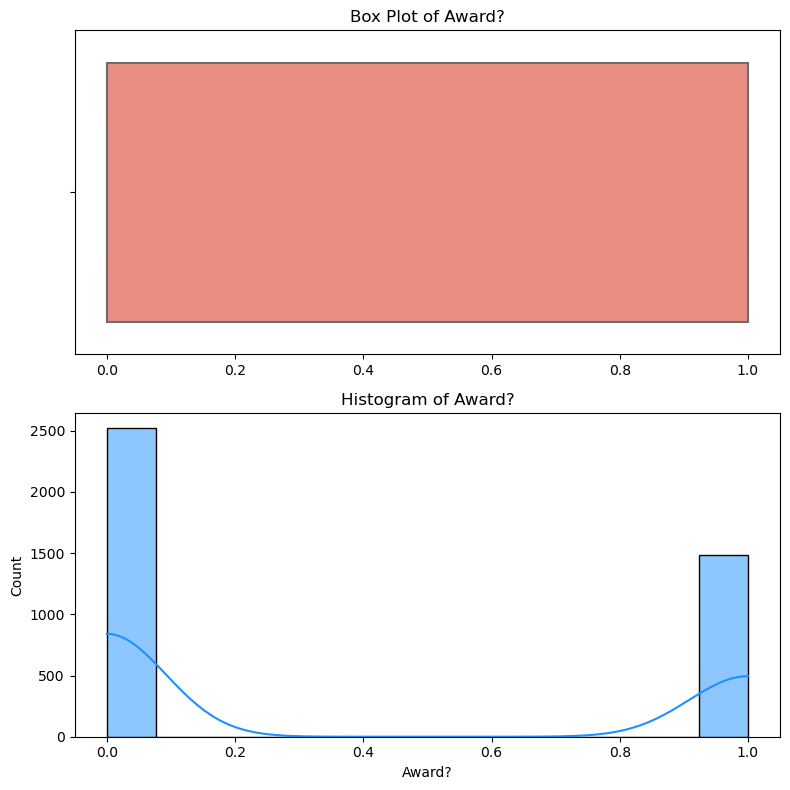

In [399]:
# Function to plot boxplot and histogram
def plot_boxplot_hist(data, column):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

    # Box plot
    sns.boxplot(x=data[column], color='salmon', ax=axes[0])
    axes[0].set_title(f'Box Plot of {column}')
    axes[0].set_xlabel('')

    # Histogram
    sns.histplot(data[column], kde=True, color='dodgerblue', ax=axes[1])
    axes[1].set_title(f'Histogram of {column}')
    axes[1].set_xlabel(column)

    plt.tight_layout()
    plt.show()

# Plot box plot and histogram for each numeric column one by one
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    plot_boxplot_hist(df, col)

In [400]:
# Function to remove outliers using Z-score method
def remove_outliers_zscore(df, threshold=3):
    z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
    df = df[(z_scores < threshold).all(axis=1)]
    return df

# Remove outliers from the dataset
df_cleaned = remove_outliers_zscore(df.drop(columns=['Award?']))

# Print the number of rows before and after removing outliers
print("Number of rows before removing outliers:", df.shape[0])
print("Number of rows after removing outliers:", df_cleaned.shape[0])

Number of rows before removing outliers: 3999
Number of rows after removing outliers: 3630


In [401]:
# Print the cleaned dataset
print("Cleaned Dataset:")
df_cleaned.head()

Cleaned Dataset:


Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  \
0    28143           0          1          1          1          174   
1    19244           0          1          1          1          215   
2    41354           0          1          1          1         4123   
3    14776           0          1          1          1          500   
4    97752           0          4          1          1        43300   

   Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll  
0            1                  0                0               7000  
1            2                  0                0               6968  
2            4                  0                0               7034  
3            1                  0                0               6952  
4           26               2077                4               6935

In [402]:
# Exclude 'Award?' column from scaling
features = df.drop(columns=['Award?'])

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert the scaled features back to a DataFrame
df = pd.DataFrame(scaled_features, columns=features.columns)
df.head()

Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  \
0 -0.451141   -0.186299  -0.769578  -0.098242  -0.062767    -0.702786   
1 -0.539457   -0.186299  -0.769578  -0.098242  -0.062767    -0.701088   
2 -0.320031   -0.186299  -0.769578  -0.098242  -0.062767    -0.539253   
3 -0.583799   -0.186299  -0.769578  -0.098242  -0.062767    -0.689286   
4  0.239678   -0.186299   1.409471  -0.098242  -0.062767     1.083121   

   Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll  
0    -1.104065          -0.328603        -0.362168           1.395454  
1    -0.999926          -0.328603        -0.362168           1.379957  
2    -0.791649          -0.328603        -0.362168           1.411920  
3    -1.104065          -0.328603        -0.362168           1.372208  
4     1.499394           1.154932         0.692490           1.363975

In [403]:
# Summary statistics
print(df.describe())

            Balance    Qual_miles     cc1_miles     cc2_miles     cc3_miles  \
count  3.999000e+03  3.999000e+03  3.999000e+03  3.999000e+03  3.999000e+03   
mean   2.842882e-17  6.574164e-17  1.705729e-16  3.038330e-16  1.350369e-16   
std    1.000125e+00  1.000125e+00  1.000125e+00  1.000125e+00  1.000125e+00   
min   -7.304396e-01 -1.862987e-01 -7.695784e-01 -9.824189e-02 -6.276658e-02   
25%   -5.465676e-01 -1.862987e-01 -7.695784e-01 -9.824189e-02 -6.276658e-02   
50%   -3.027332e-01 -1.862987e-01 -7.695784e-01 -9.824189e-02 -6.276658e-02   
75%    1.866028e-01 -1.862987e-01  6.831212e-01 -9.824189e-02 -6.276658e-02   
max    1.618884e+01  1.422486e+01  2.135821e+00  1.344898e+01  2.042732e+01   

        Bonus_miles   Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
count  3.999000e+03  3.999000e+03        3999.000000     3.999000e+03   
mean  -2.842882e-17 -7.817925e-17           0.000000     1.776801e-17   
std    1.000125e+00  1.000125e+00           1.000125     1.000125e+00

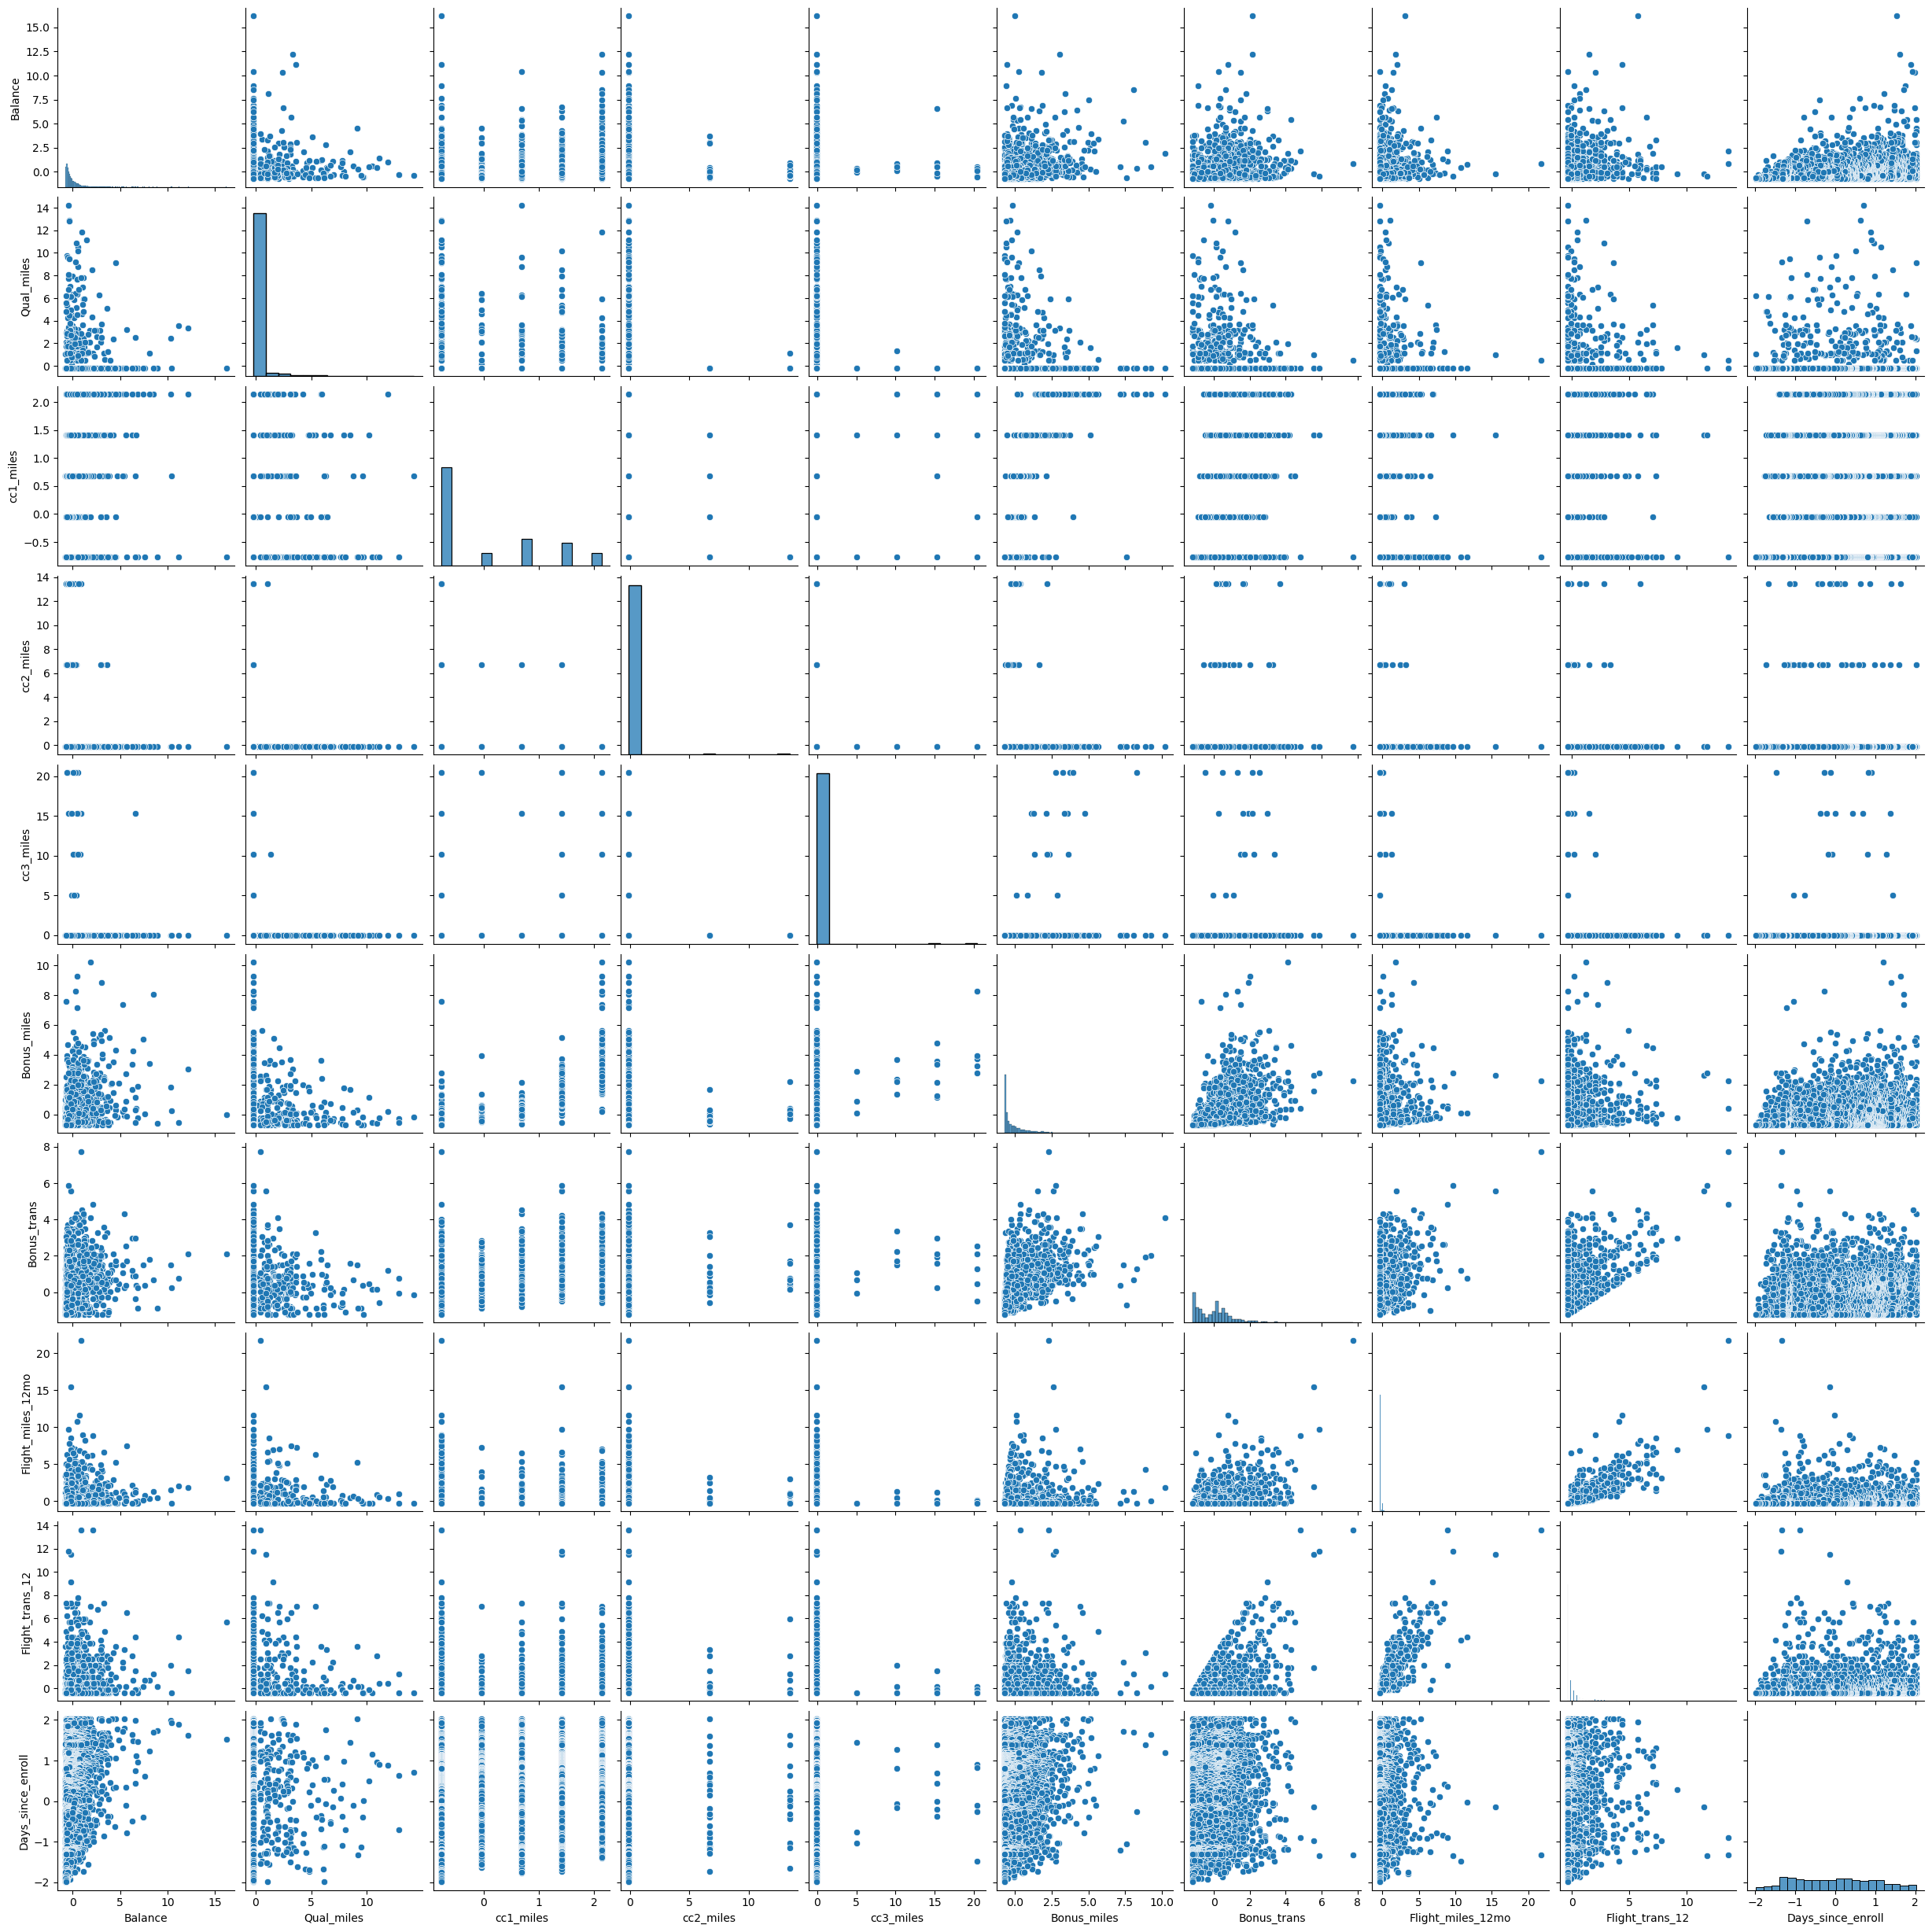

In [404]:
# Pair plot to visualize relationships
sns.pairplot(df)
plt.show()

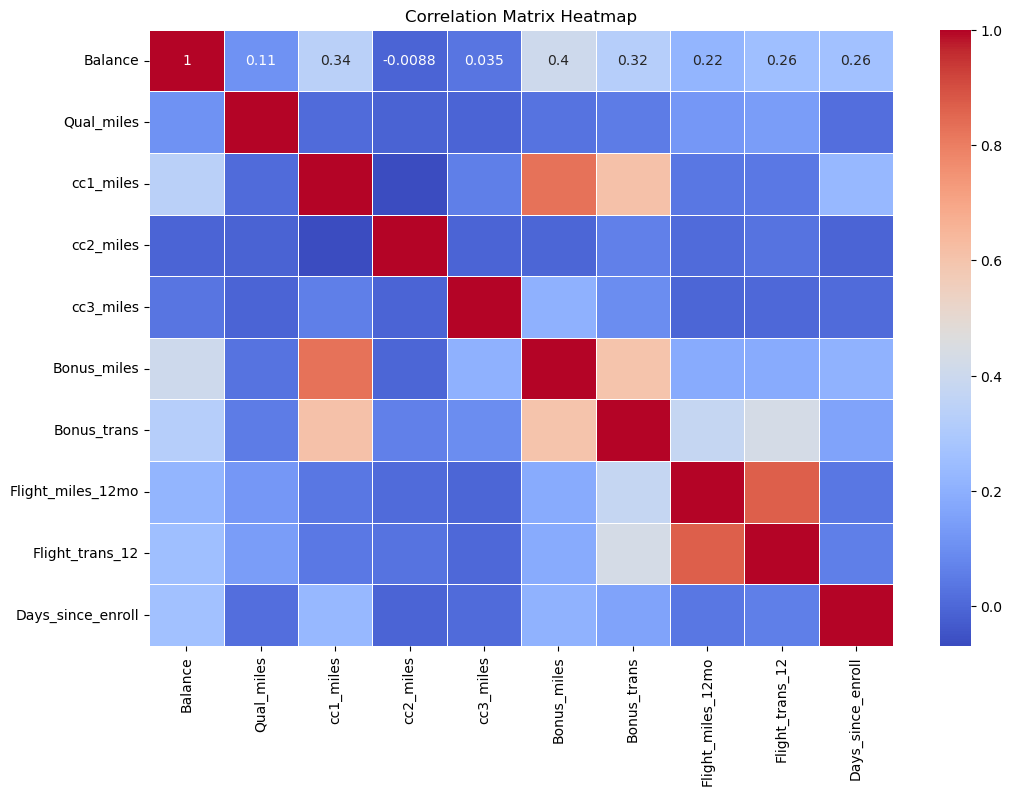

In [405]:
# Correlation matrix
correlation_matrix = df.corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

## K-Means clustering

In [406]:
# Apply K-Means clustering to the dataset
kmeans = KMeans(n_clusters=3) # Randomly select a value
cluster=kmeans.fit(df)

In [407]:
# Access the cluster labels
cluster.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [408]:
# Get unique cluster labels
np.unique(cluster.labels_)

array([0, 1, 2])

In [409]:
# Create cluster column
df['cluster'] = cluster.labels_

In [410]:
# Display the created cluster column
df[df['cluster']==2]

Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  \
4     0.239678   -0.186299   1.409471  -0.098242  -0.062767     1.083121   
6     0.112270   -0.186299   0.683121  -0.098242  -0.062767     0.428076   
9     0.310220   -0.186299   0.683121  -0.098242  -0.062767     0.467168   
11    0.227471   -0.186299   2.135821  -0.098242  -0.062767     1.820451   
12   -0.299905   -0.186299  -0.043229  -0.098242  -0.062767    -0.248255   
...        ...         ...        ...        ...        ...          ...   
3974 -0.150991   -0.186299   0.683121  -0.098242  -0.062767    -0.106172   
3979 -0.156886   -0.186299   0.683121  -0.098242  -0.062767     0.157949   
3980 -0.443956   -0.186299   0.683121  -0.098242  -0.062767     0.083823   
3985 -0.144739   -0.186299   1.409471  -0.098242  -0.062767     0.728888   
3991 -0.341984   -0.186299   0.683121  -0.098242  -0.062767    -0.089608   

      Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll  \
4        1.499394           1.154932         0.692490           1.363975   
6        1.395256          -0.328603        -0.362168           1.392549   
9        1.707671           0.492805         0.428826           1.362038   
11       0.770426          -0.328603        -0.362168           1.358648   
12       0.874564          -0.328603        -0.362168           1.358648   
...           ...                ...              ...                ...   
3974     2.853193          -0.328603        -0.362168          -1.299622   
3979     0.353873           0.527090         0.428826          -1.304950   
3980     1.707671          -0.328603        -0.362168          -1.304465   
3985     1.395256          -0.328603        -0.362168          -1.307855   
3991     1.707671          -0.328603        -0.362168          -1.312698   

      cluster  
4           2  
6           2  
9           2  
11          2  
12          2  
...       ...  
3974        2  
3979        2  
3980        2  
3985        2  
3991        2  

[1326 rows x 11 columns]

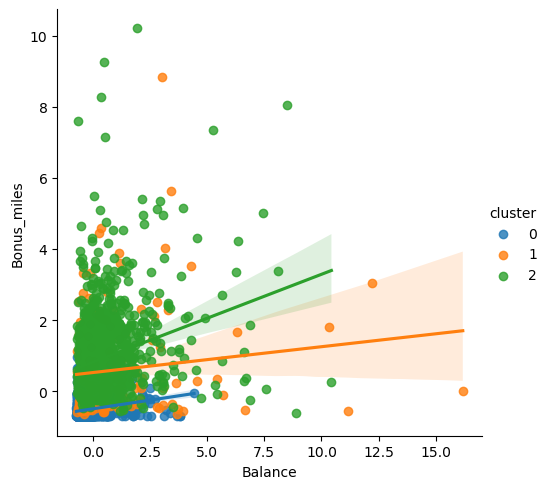

In [411]:
# Plot a linear model fit with the data, using 'Balance' and 'Bonus_miles' features, colored by cluster
sns.lmplot(data=df, x='Balance', y='Bonus_miles', hue='cluster')

In [412]:
# Access cluster centroids
cluster.cluster_centers_

array([[-3.03933496e-01, -5.20847786e-02, -6.36149538e-01,
         3.64223024e-02, -6.07297920e-02, -5.26494438e-01,
        -5.02587860e-01, -1.76587647e-01, -1.91179058e-01,
        -2.03298967e-01],
       [ 1.18237420e+00,  8.49204867e-01,  8.01137971e-02,
         1.57365990e-01, -6.27665798e-02,  6.09001693e-01,
         1.64806999e+00,  3.58565902e+00,  3.88299703e+00,
         2.98807417e-01],
       [ 4.35015279e-01, -3.04177789e-03,  1.19787018e+00,
        -8.80175720e-02,  1.22804010e-01,  9.26265844e-01,
         7.56200256e-01, -9.50957368e-02, -1.03080150e-01,
         3.50027565e-01]])

In [413]:
# Calculate Silhouette Score
kmeans_score = silhouette_score(df, cluster.labels_)
print(f"Silhouette Score: {kmeans_score}")

Silhouette Score: 0.41778851188355653


In [414]:
# Find best metrics using Elbow method
kmeans.fit(df)

KMeans(n_clusters=3)

In [415]:
# Access inertia
kmeans.inertia_

27559.43970600169

In [416]:
# Find best metrics
inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)
print(inertia)

[43477.07576894222, 32347.655027214958, 27559.439706001693, 23810.22987295393, 20361.987895820625, 17788.115030388202, 16015.388819227472, 14496.282031267798, 13456.538439171029, 12463.637081468143]


Text(0.5, 1.0, 'elbow method')

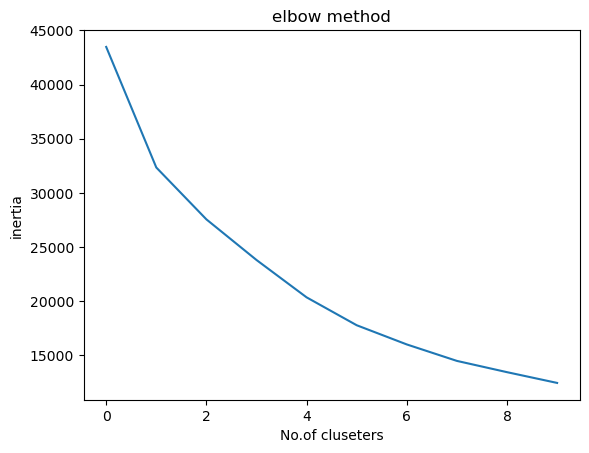

In [417]:
# Plot graph
plt.plot(range(10), inertia)
plt.xlabel('No.of cluseters')
plt.ylabel('inertia')
plt.title('elbow method')

In [418]:
# Perform K-Means clustering
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
cluster=kmeans.fit(df)

In [419]:
# Get unique cluster labels
np.unique(cluster.labels_)

array([0, 1, 2, 3])

In [420]:
df = df.drop('cluster', axis=1)
df.head()

Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  \
0 -0.451141   -0.186299  -0.769578  -0.098242  -0.062767    -0.702786   
1 -0.539457   -0.186299  -0.769578  -0.098242  -0.062767    -0.701088   
2 -0.320031   -0.186299  -0.769578  -0.098242  -0.062767    -0.539253   
3 -0.583799   -0.186299  -0.769578  -0.098242  -0.062767    -0.689286   
4  0.239678   -0.186299   1.409471  -0.098242  -0.062767     1.083121   

   Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll  
0    -1.104065          -0.328603        -0.362168           1.395454  
1    -0.999926          -0.328603        -0.362168           1.379957  
2    -0.791649          -0.328603        -0.362168           1.411920  
3    -1.104065          -0.328603        -0.362168           1.372208  
4     1.499394           1.154932         0.692490           1.363975

In [421]:
df['cluster'] = cluster.labels_
df['cluster']

0       0
1       0
2       0
3       0
4       1
       ..
3994    0
3995    0
3996    0
3997    0
3998    0
Name: cluster, Length: 3999, dtype: int32

In [422]:
cluster.cluster_centers_

array([[-3.04097941e-01, -5.20313920e-02, -6.36674308e-01,
         3.64758681e-02, -6.07289818e-02, -5.26598871e-01,
        -5.02721419e-01, -1.76527180e-01, -1.91111043e-01,
        -2.03641906e-01,  1.77635684e-15],
       [ 4.32424818e-01, -2.25031315e-03,  1.19948883e+00,
        -8.79083879e-02, -5.49519018e-02,  8.99575076e-01,
         7.44530369e-01, -9.67428260e-02, -1.05140196e-01,
         3.51523480e-01,  2.00000000e+00],
       [ 1.18237420e+00,  8.49204867e-01,  8.01137971e-02,
         1.57365990e-01, -6.27665798e-02,  6.09001693e-01,
         1.64806999e+00,  3.58565902e+00,  3.88299703e+00,
         2.98807417e-01,  1.00000000e+00],
       [ 6.39719256e-01, -8.44329231e-02,  1.02208440e+00,
        -9.82418871e-02,  1.56462993e+01,  3.17969131e+00,
         1.71461374e+00,  3.32926913e-02,  5.96953922e-02,
         2.39872612e-01,  2.00000000e+00]])

In [423]:
# Calculate Silhoutte score with best metrics
kmeans_score = silhouette_score(df, cluster.labels_)
print(f"Silhouette Score: {kmeans_score}")

Silhouette Score: 0.36176679542971546


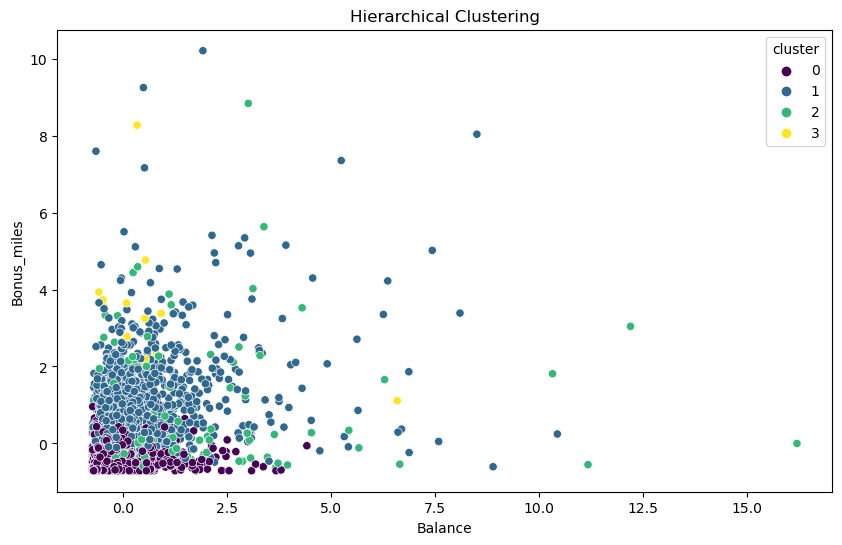

In [424]:
# Scatter plot for Hierarchical clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Balance', y='Bonus_miles', hue='cluster', data=df, palette='viridis')
plt.title('Hierarchical Clustering')
plt.show()

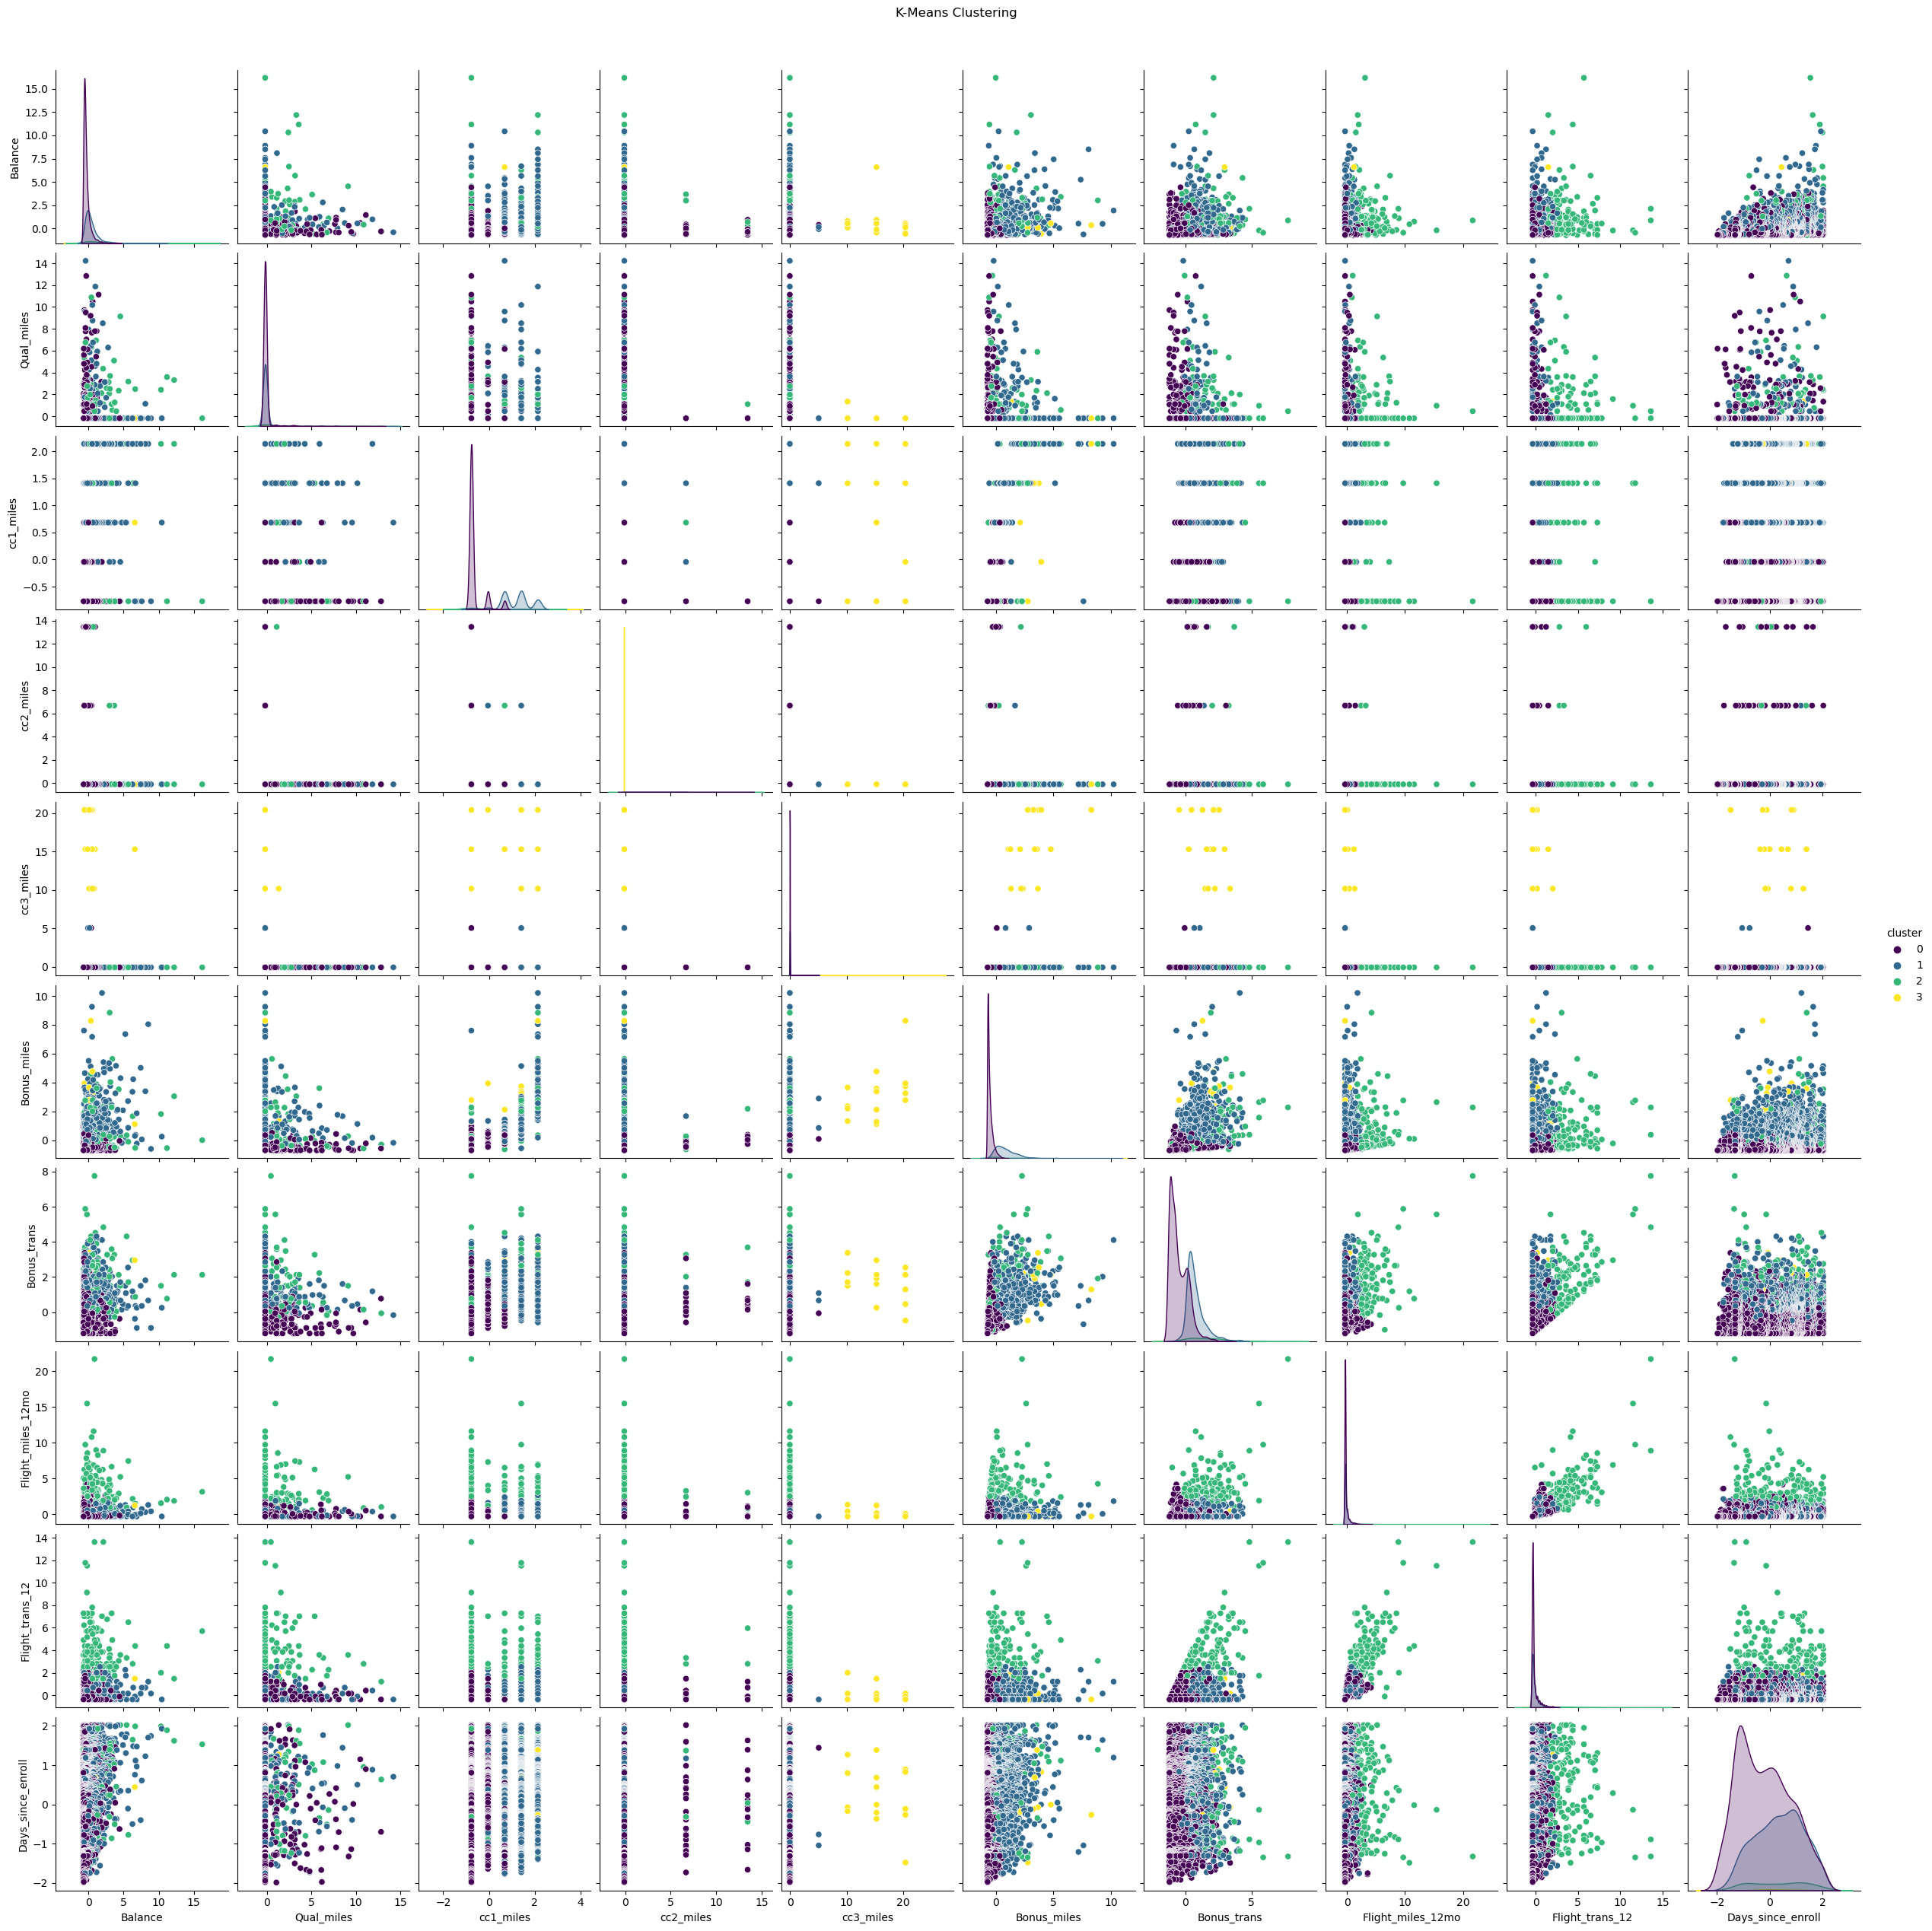

In [425]:
# Pair plot for K-Means clustering
sns.pairplot(df, vars=['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles', 'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll'], hue='cluster', palette='viridis')
plt.suptitle('K-Means Clustering', y=1.02)
plt.show()

# Remove the 'cluster' column
df.drop(columns=['cluster'], inplace=True)

## Hierarchical Clustering

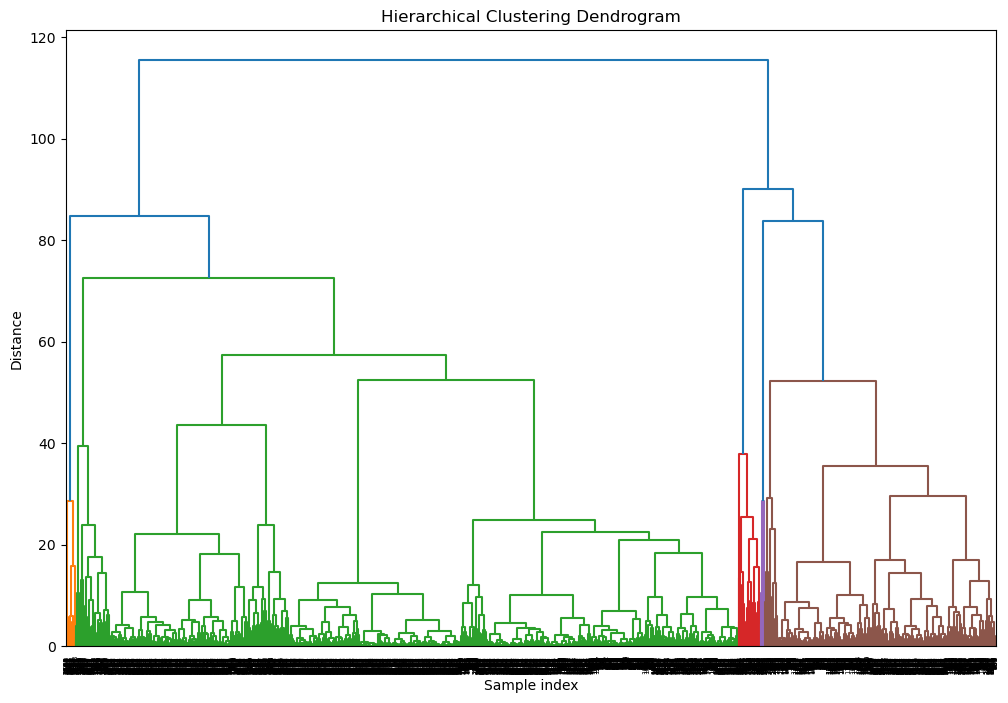

In [426]:
# Create the linkage matrix
linkage_matrix = linkage(df, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [427]:
# Apply AgglomerativeClustering
hierarchical = AgglomerativeClustering(n_clusters=2, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(df)

# Add the cluster labels to the original dataframe
df['Hierarchical_Cluster'] = hierarchical_labels
print(df['Hierarchical_Cluster'].value_counts())

Hierarchical_Cluster
1    2893
0    1106
Name: count, dtype: int64


In [428]:
# Calculate Silhouette score
hc_score = silhouette_score(df, hierarchical_labels)
print(f"Silhouette Score: {hc_score}")

Silhouette Score: 0.348107258618321


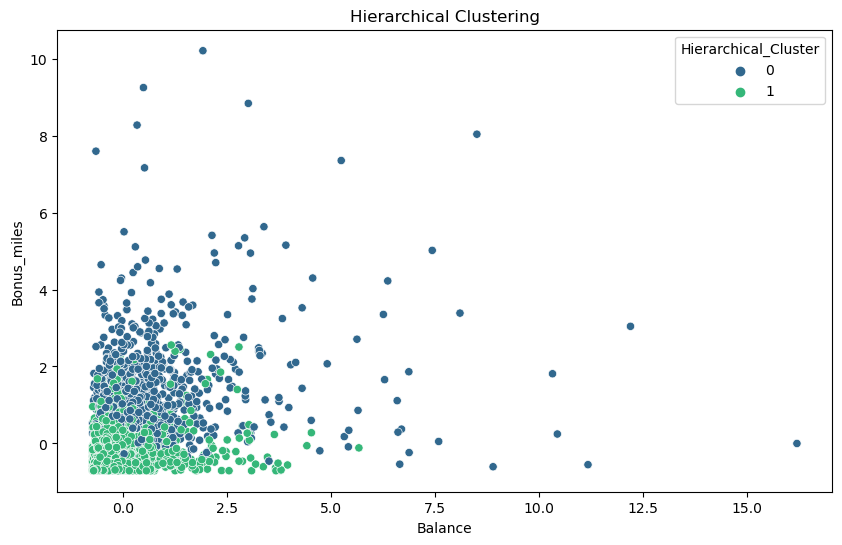

In [429]:
# Scatter plot for Hierarchical clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Balance', y='Bonus_miles', hue='Hierarchical_Cluster', data=df, palette='viridis')
plt.title('Hierarchical Clustering')
plt.show()

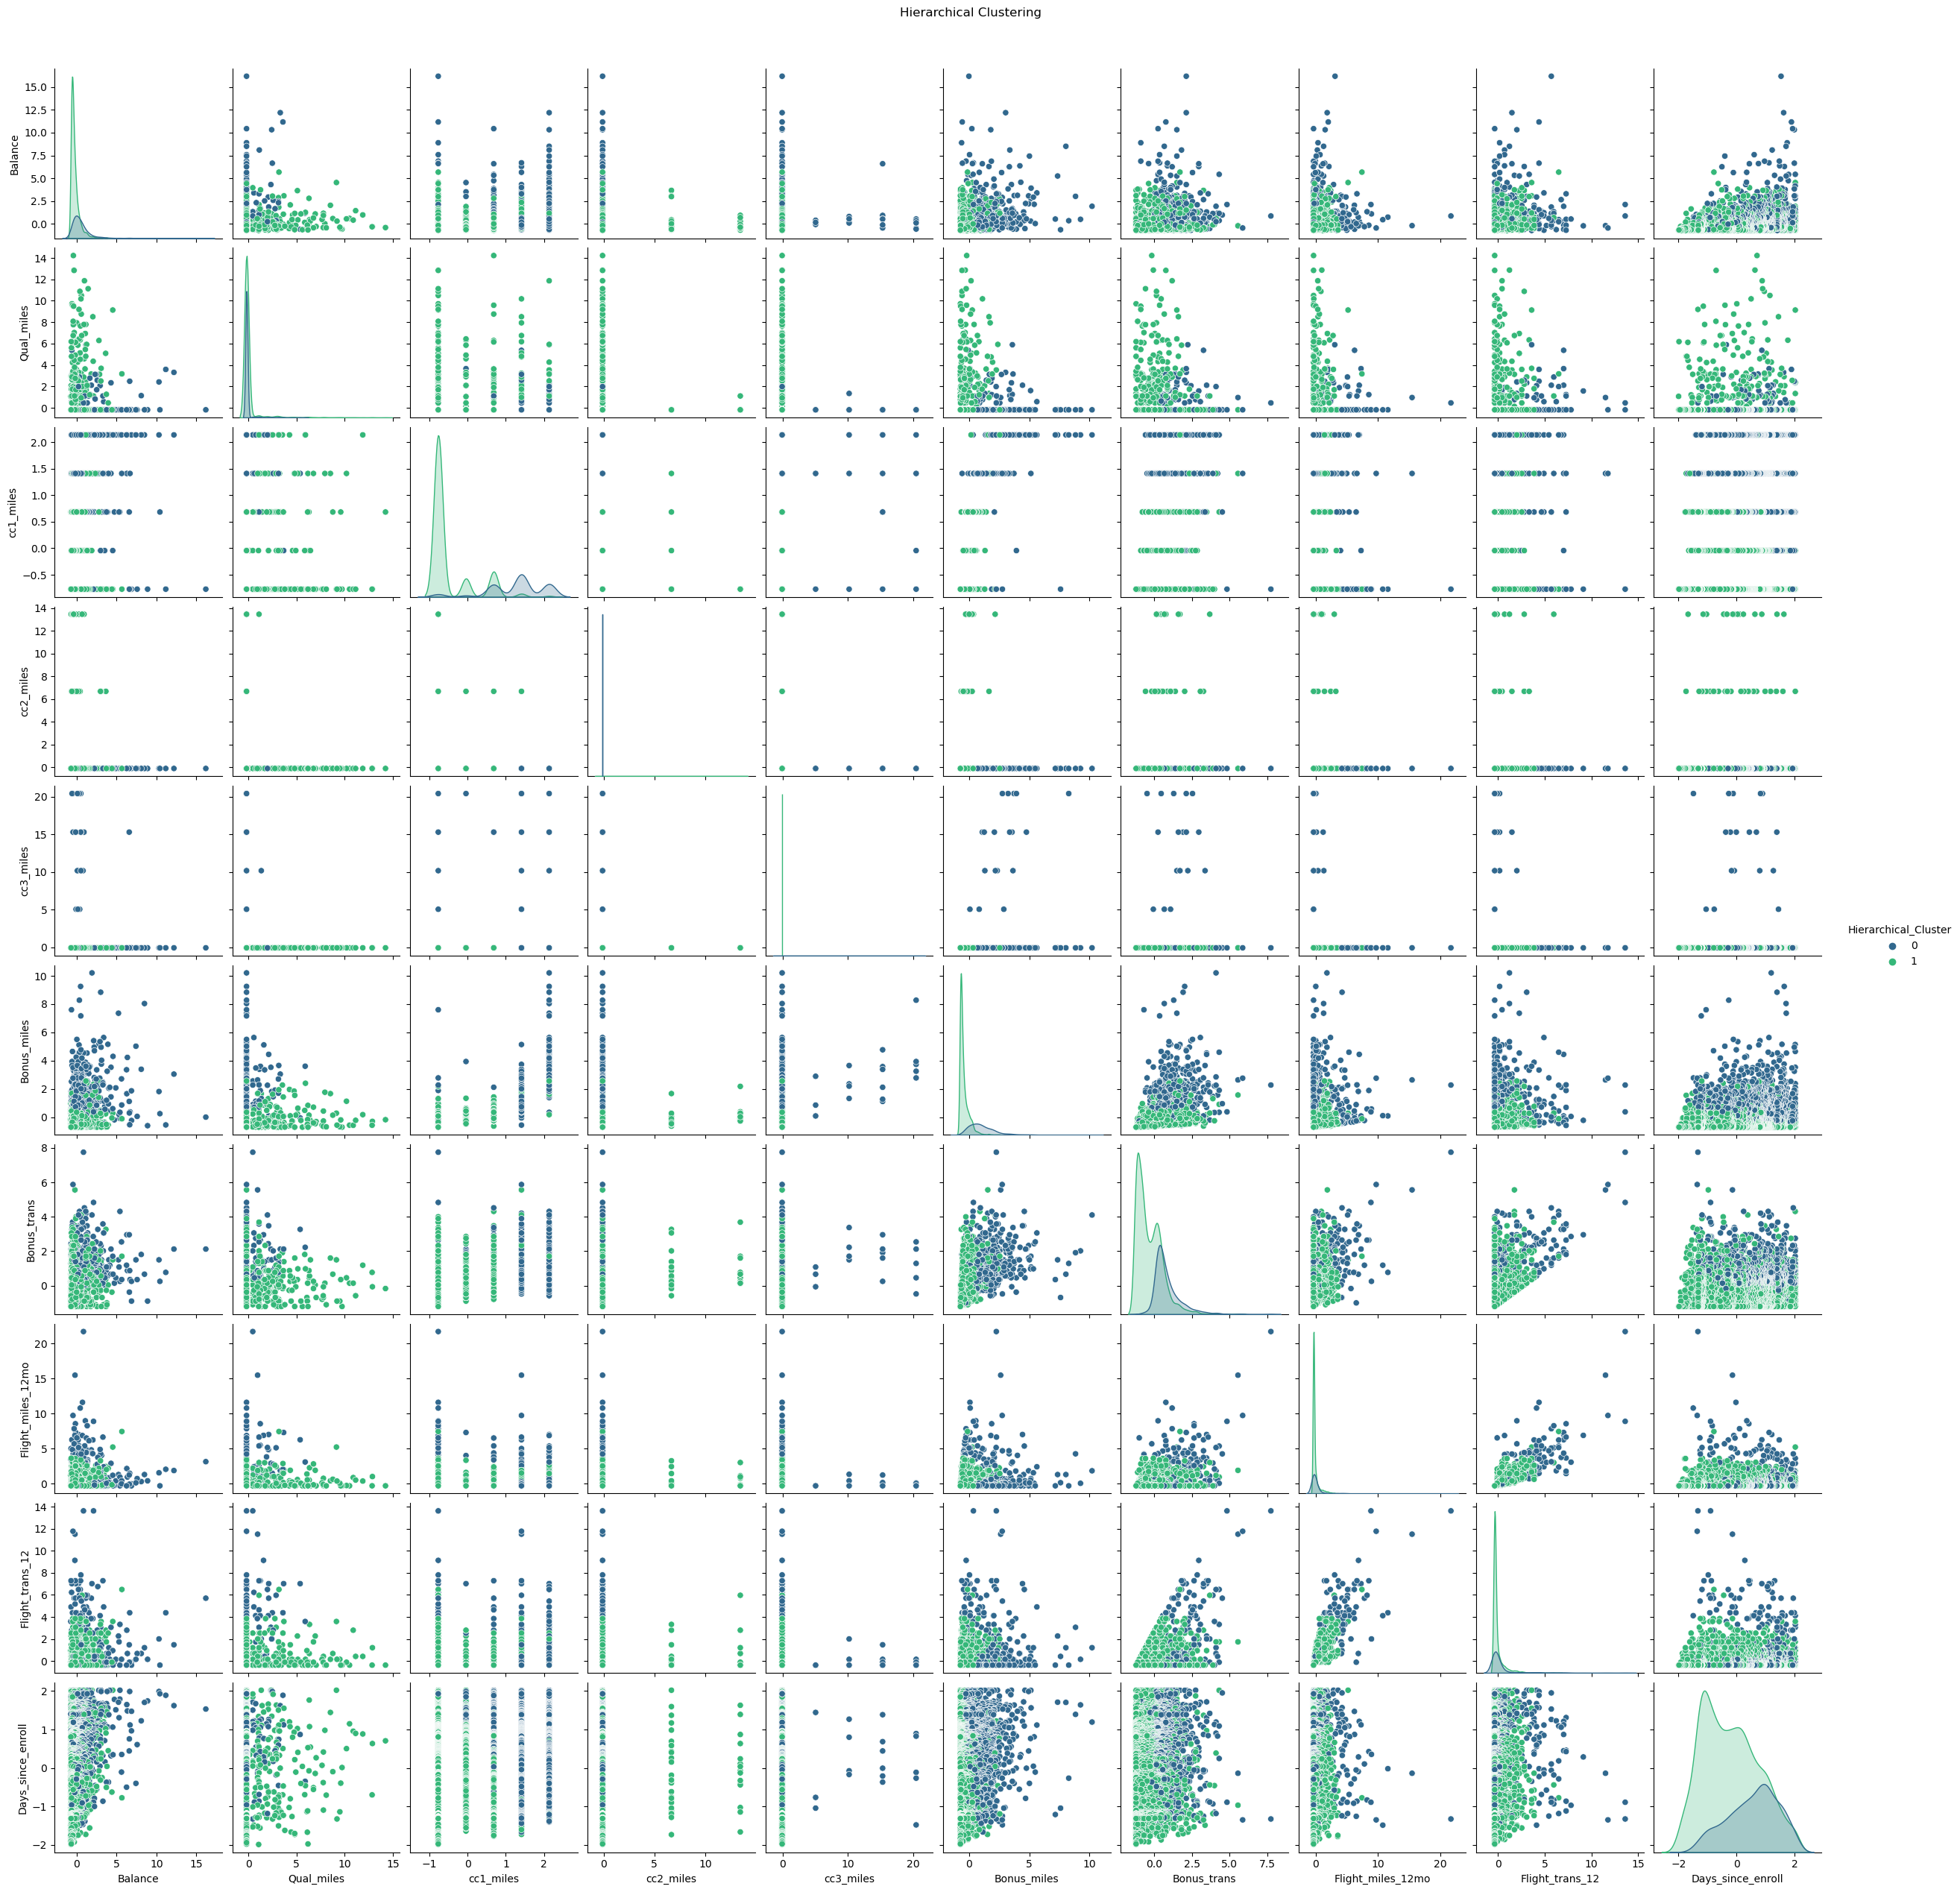

In [430]:
# Pair plot for Hierarchical clustering
sns.pairplot(df, vars=['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles', 'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll'], hue='Hierarchical_Cluster', palette='viridis')
plt.suptitle('Hierarchical Clustering', y=1.02)
plt.show()

## DBSCAN Clustering

In [431]:
# Choose randomly epsilon and min_samples values
epsilon = 0.5
min_samples = 5
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(df)

# Add the cluster labels to the original dataframe
df['DBSCAN_Cluster'] = dbscan_labels
print(df['DBSCAN_Cluster'].value_counts())

DBSCAN_Cluster
 0     1796
-1     1234
 4      272
 9      256
 5      178
 7      163
 2       40
 1       11
 11      10
 3        7
 12       7
 14       6
 6        5
 8        5
 13       5
 10       4
Name: count, dtype: int64


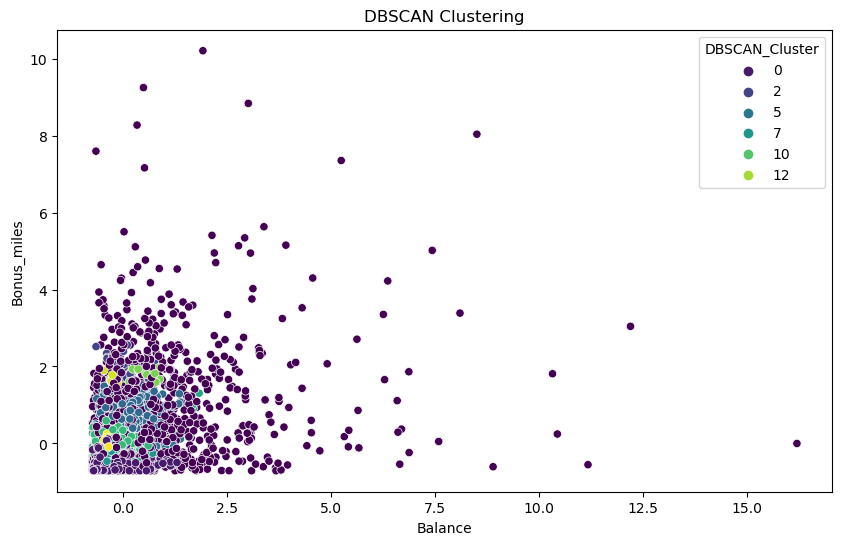

In [432]:
# Scatter plot for DBSCAN clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Balance', y='Bonus_miles', hue='DBSCAN_Cluster', data=df, palette='viridis')
plt.title('DBSCAN Clustering')
plt.show()

In [433]:
# Silhouette score for DBSCAN clustering
silhouette_dbscan = silhouette_score(df, dbscan_labels)
print(f"Silhouette Score: {silhouette_dbscan}")

Silhouette Score: 0.23178974013224185


In [434]:
# Define the range of values for epsilon and min_samples
epsilon_range = np.arange(0.1, 1.1, 0.1)
min_samples_range = range(2, 11)

# Initialize variables to store the best parameters and score
best_epsilon = None
best_min_samples = None
best_score = -1

# Loop over the parameter combinations
for epsilon in epsilon_range:
    for min_samples in min_samples_range:
        # Create the DBSCAN model
        dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
        
        # Fit the model and get the cluster labels
        dbscan_labels = dbscan.fit_predict(df)
        
        # Calculate the silhouette score
        score = silhouette_score(df, dbscan_labels)
        
        # Update the best parameters and score
        if score > best_score:
            best_epsilon = epsilon
            best_min_samples = min_samples
            best_score = score
            
# Print the best parameters and score
print(f"Best epsilon: {best_epsilon}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best silhouette score: {best_score:.3f}")

Best epsilon: 1.0
Best min_samples: 4
Best silhouette score: 0.264


In [438]:
# Choose randomly epsilon and min_samples based on the K-Distance Graph
epsilon = 1
min_samples = 4
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(df)

# Add the cluster labels to the original dataframe
df['DBSCAN_Cluster'] = dbscan_labels
print(df['DBSCAN_Cluster'].value_counts())

DBSCAN_Cluster
 0     1796
-1      500
 8      345
 1      323
 5      272
 7      256
 6      178
 11     163
 3       40
 23      12
 2       11
 22      10
 13      10
 15       7
 21       7
 4        7
 25       6
 9        6
 26       6
 19       5
 12       5
 20       5
 10       5
 18       4
 16       4
 14       4
 24       4
 17       4
 27       4
Name: count, dtype: int64


In [439]:
# Silhouette score for DBSCAN clustering
silhouette_dbscan = silhouette_score(df, dbscan_labels)
print(f"Silhouette Score: {silhouette_dbscan}")

Silhouette Score: 0.3362168421517141


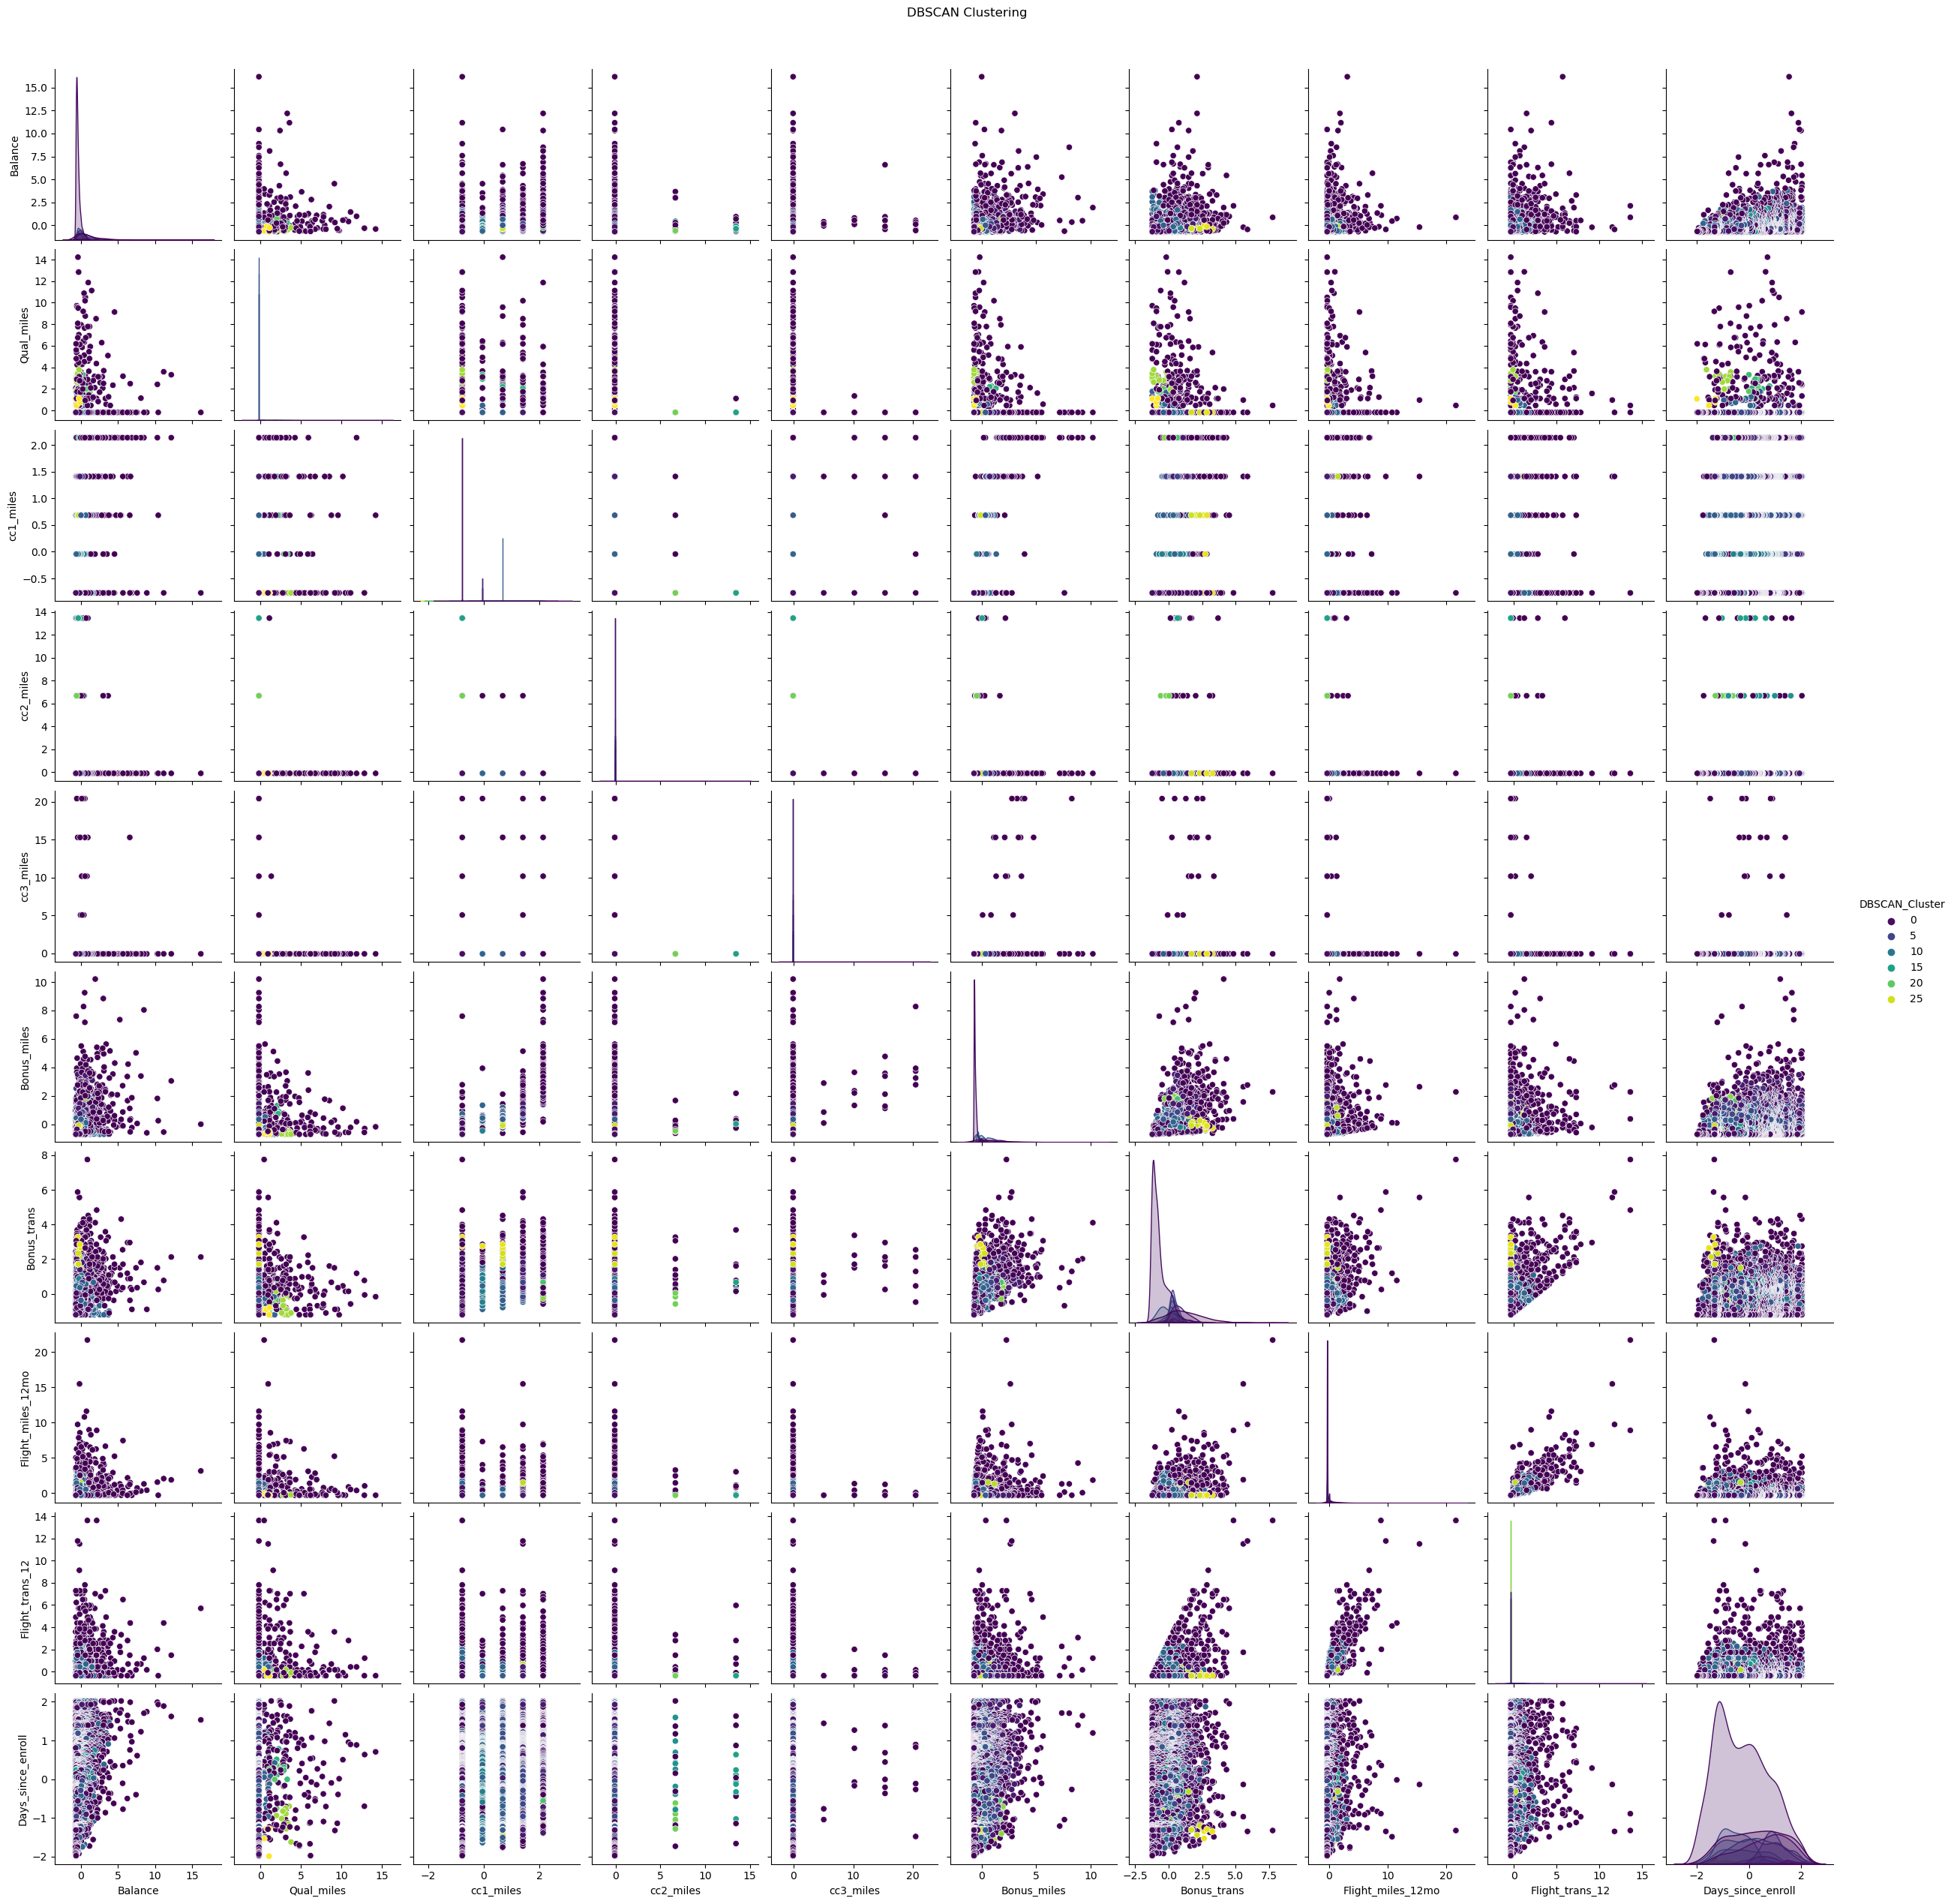

In [440]:
# Pair plot for DBSCAN clustering
sns.pairplot(df, vars=['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles', 'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll'], hue='DBSCAN_Cluster', palette='viridis')
plt.suptitle('DBSCAN Clustering', y=1.02)
plt.show()